In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import sqlite3
import mysql.connector as cnt
import plotly.express as px
import requests
from datetime import datetime, timedelta
from bs4 import BeautifulSoup
import os
import selenium
from selenium.webdriver.chrome.options import Options
from selenium import webdriver
from bs4 import BeautifulSoup
import time

In [2]:
SDB = sqlite3.connect('autoplius4.db') # jei neegsiztuoja - bus sukurfta nauja sqlite DB
Cs = SDB.cursor()

sql="""SELECT * FROM T1;"""
Cs.execute(sql)
ans = Cs.fetchall()
gamintojas, modelis, kaina, metai, kebulas, kuras, pavaros, galingumas, rida, nuorodos, pirmaregistracija, technikine = list(map(list, zip(*ans)))

# df = pd.DataFrame(ans, columns=['gamintojas', 'price', 'data', 'rida', 'pavaros', 'variklis'])
# df.head(2)

df = pd.read_sql_query(sql, con=SDB)
df.head(3)

,gamintojas,modelis,kaina,metai,kebulas,kuras,pavaros,galingumas,rida,nuorodos,pirmaregistracija,technikine
0,BMW,428 Gran Coupe,18000,2015.0,Kupė (Coupe),Benzinas,Automatinė,180,199000.0,https://autoplius.lt/skelbimai/bmw-428-gran-co...,JAV,None
1,Volkswagen,Golf,7100,2014.0,Universalas,Dyzelinas,Automatinė,77,314086.0,https://autoplius.lt/skelbimai/volkswagen-golf...,Prancūzija,None
2,Fiat,500X,10500,2016.0,Visureigis / Krosoveris,Benzinas / dujos,Automatinė,130,126211.0,https://autoplius.lt/skelbimai/fiat-500x-2-4-l...,JAV,2026-10


In [ ]:
# Įvertinkite automobilių kainos priklausomybes nuo ridos, amžiaus, variklio galios, kėbulo ti-
# po, pavarų dėžės tipo

In [22]:
df['amzius']=2024-df['metai']

df['ridosintervalai'] = np.ceil(df['rida'] / 20000) * 20000

df.head()

,gamintojas,modelis,kaina,metai,kebulas,kuras,pavaros,galingumas,rida,nuorodos,pirmaregistracija,technikine,amzius,ridosintervalai
0,BMW,428 Gran Coupe,18000,2015.0,Kupė (Coupe),Benzinas,Automatinė,180,199000.0,https://autoplius.lt/skelbimai/bmw-428-gran-co...,JAV,None,9.0,200000.0
1,Volkswagen,Golf,7100,2014.0,Universalas,Dyzelinas,Automatinė,77,314086.0,https://autoplius.lt/skelbimai/volkswagen-golf...,Prancūzija,None,10.0,320000.0
2,Fiat,500X,10500,2016.0,Visureigis / Krosoveris,Benzinas / dujos,Automatinė,130,126211.0,https://autoplius.lt/skelbimai/fiat-500x-2-4-l...,JAV,2026-10,8.0,140000.0
3,Skoda,Octavia,2500,2010.0,Hečbekas,Dyzelinas,Mechaninė,77,318000.0,https://autoplius.lt/skelbimai/skoda-octavia-1...,Lietuva,2025-09,14.0,320000.0
4,BMW,525,4499,2008.0,Universalas,Dyzelinas,Automatinė,145,270000.0,https://autoplius.lt/skelbimai/bmw-525-2-5-l-u...,Vokietija,2025-06,16.0,280000.0


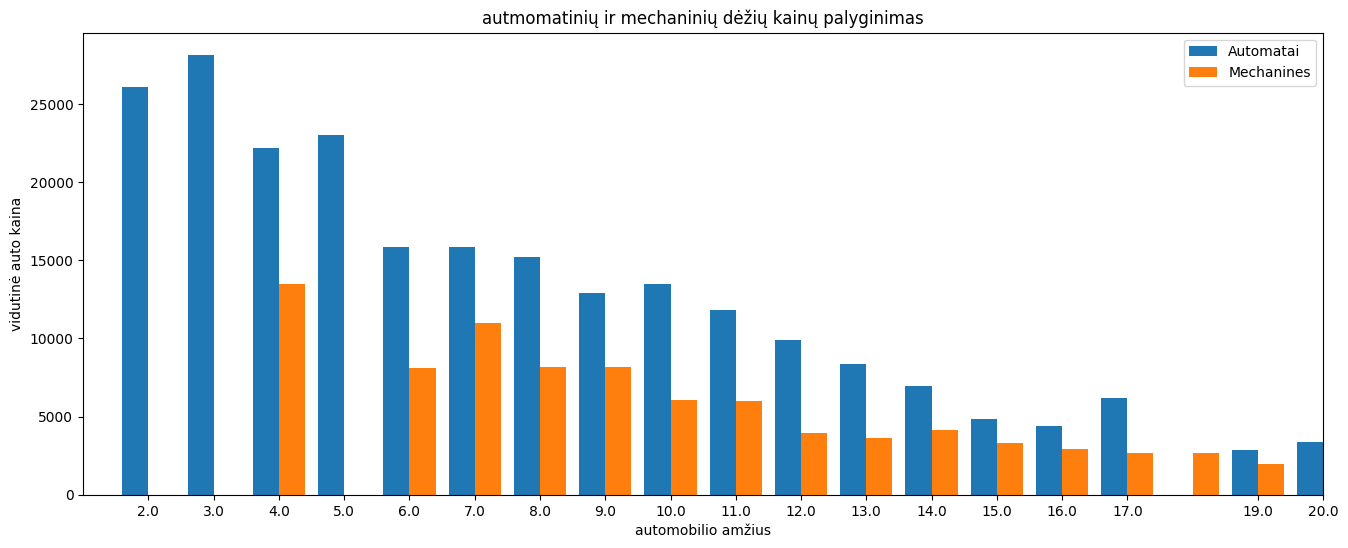

In [19]:
dfA=df[df['pavaros']=='Automatinė']
dfM=df[df['pavaros']=='Mechaninė']
dfgA = dfA[['amzius', 'kaina']].groupby('amzius').mean(numeric_only=True).reset_index()
dfgM = dfM[['amzius', 'kaina']].groupby('amzius').mean(numeric_only=True).reset_index()

fig, axis = plt.subplots(figsize=[16, 6])
x = dfgA['amzius']
x2=dfgM['amzius']
w = 0.4
i = axis.bar(x-w/2,dfgA['kaina'], label='Automatai', width=w)
o = axis.bar(x2+w/2, dfgM['kaina'], label='Mechanines', width=w)

axis.set_xticks(x)
axis.set_xticklabels(dfgA['amzius'])
axis.set_xlim(left=min(x) - 1, right=20)
axis.legend(loc='best')
axis.set_xlabel('automobilio amžius')
axis.set_ylabel('vidutinė auto kaina')
plt.title('autmomatinių ir mechaninių dėžių kainų palyginimas')
plt.show()

In [25]:
dfrida = df.groupby('ridosintervalai')['kaina'].mean().reset_index()

# Optionally, rename the columns for clarity
dfrida.columns = ['ridosintervalai', 'vidutinekaina']
dfrida['vidutinekaina']=round(dfrida['vidutinekaina'], 0)

dfrida.head()

,ridosintervalai,vidutinekaina
0,20000.0,63900.0
1,40000.0,29400.0
2,60000.0,27122.0
3,80000.0,19278.0
4,100000.0,28556.0


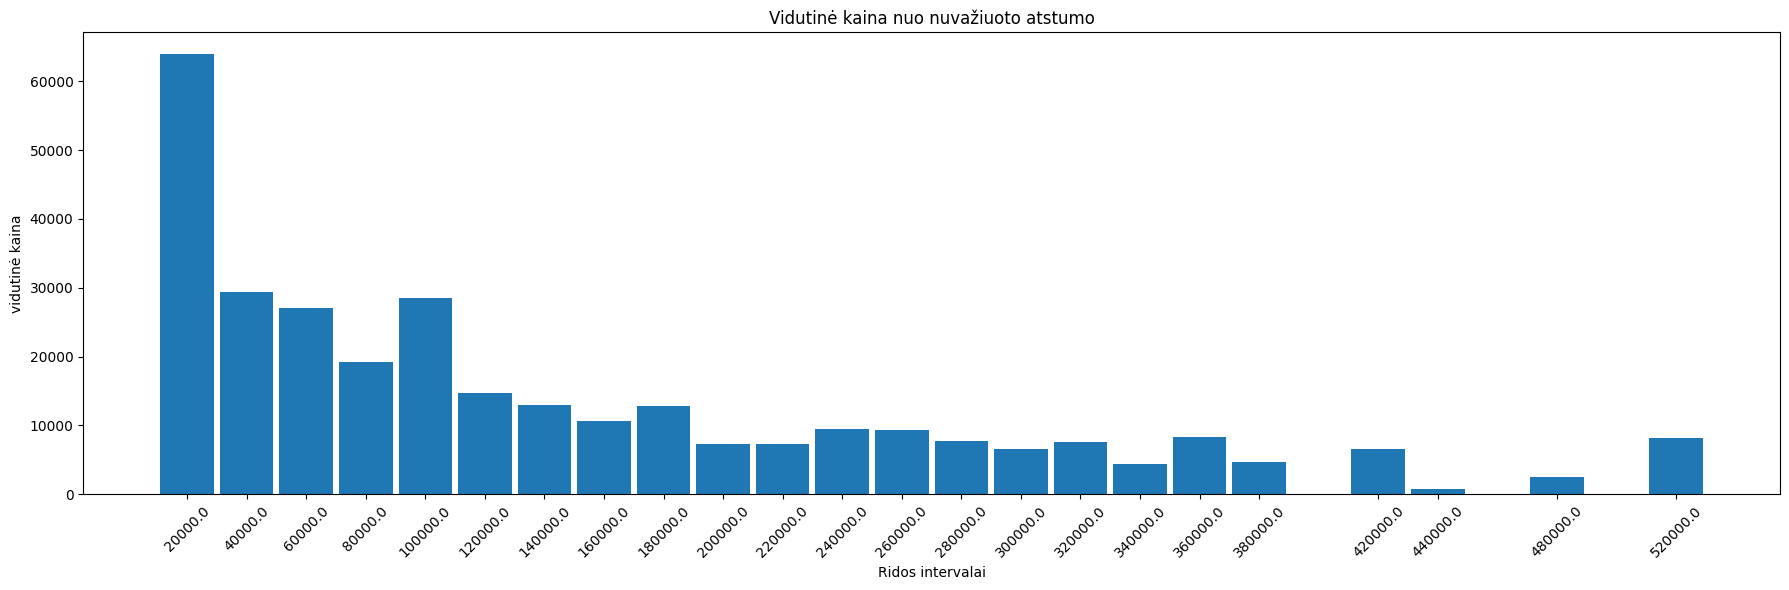

In [43]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfrida['ridosintervalai'], dfrida['vidutinekaina'], width=18000)
axis.set_xticks(dfrida['ridosintervalai'])
axis.set_xticklabels(dfrida['ridosintervalai'], rotation=45)

axis.set_xlabel('Ridos intervalai')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina nuo nuvažiuoto atstumo')

plt.tight_layout()
plt.show()

In [49]:
dfamzius = df.groupby('amzius')['kaina'].mean().reset_index()

dfamzius['kaina']=round(dfamzius['kaina'], 0)

dfamzius.head()

,amzius,kaina
0,1.0,40400.0
1,2.0,26100.0
2,3.0,28165.0
3,4.0,21100.0
4,5.0,23717.0


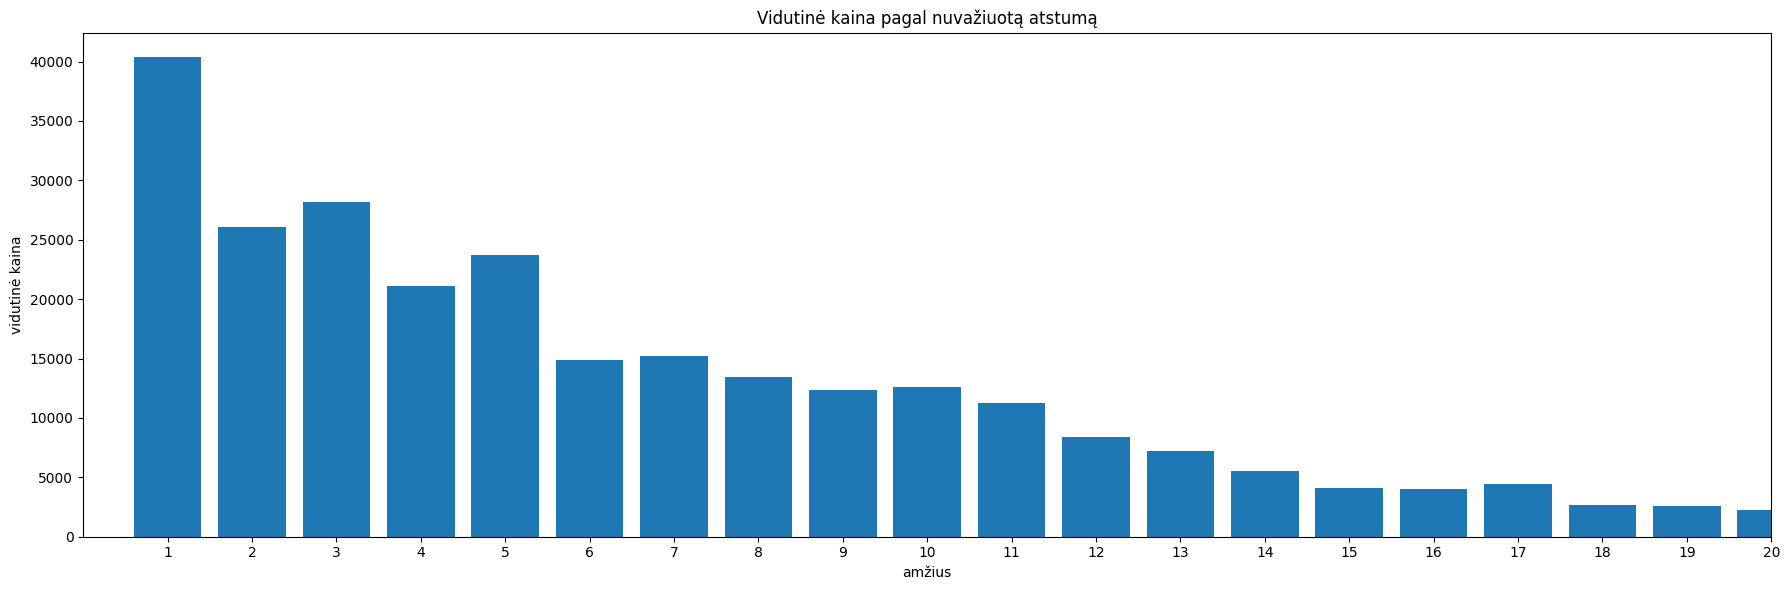

In [56]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfamzius['amzius'], dfamzius['kaina'])
axis.set_xticks(dfamzius['amzius'])
axis.set_xlabel('amžius')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal nuvažiuotą atstumą')
axis.set_xlim(left=0, right=20)

plt.tight_layout()
plt.show()

In [58]:
dfkw = df.groupby('galingumas')['kaina'].mean().reset_index()

dfkw['kaina']=round(dfamzius['kaina'], 0)

dfkw.head()

,galingumas,kaina
0,100,40400.0
1,103,26100.0
2,104,28165.0
3,105,21100.0
4,110,23717.0


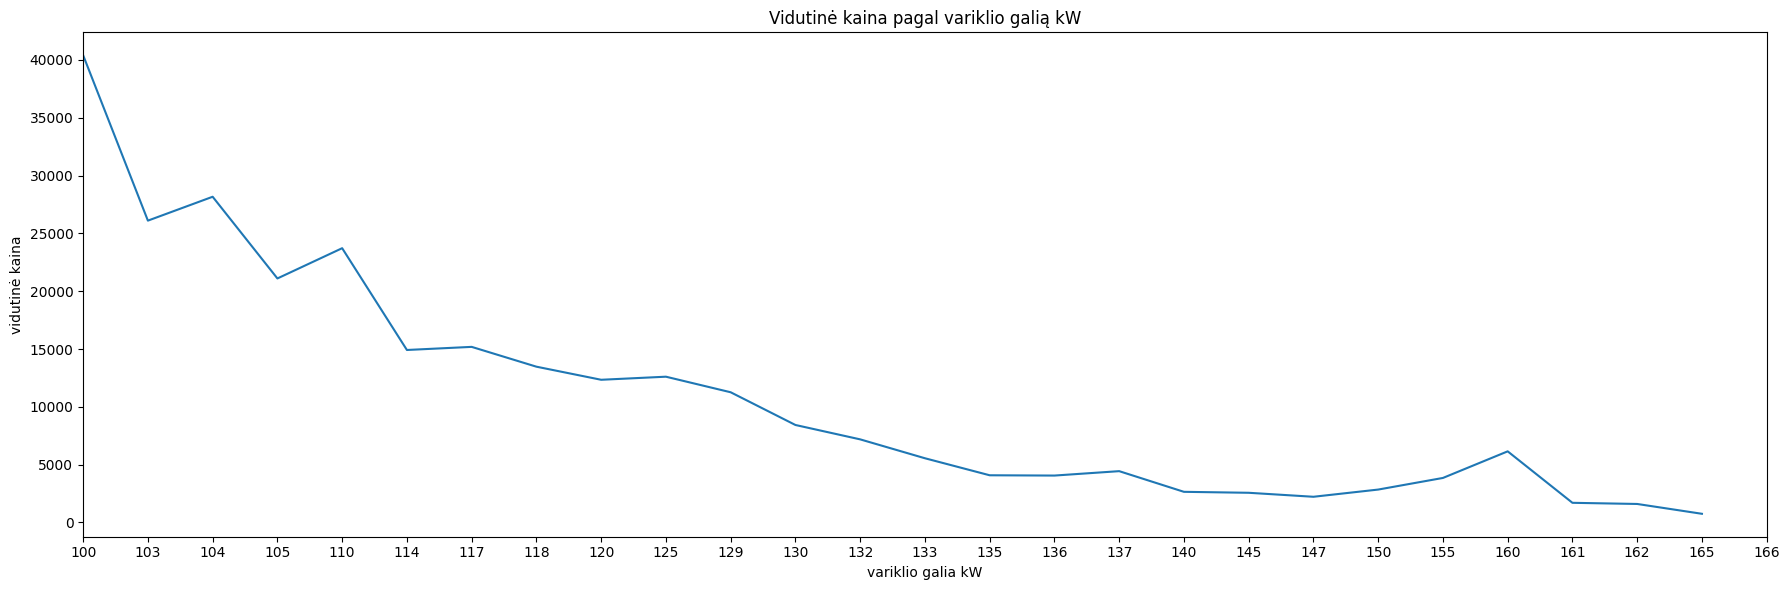

In [65]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.plot(dfkw['galingumas'], dfkw['kaina'])
axis.set_xticks(dfkw['galingumas'])
axis.set_xlabel('variklio galia kW')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal variklio galią kW')
axis.set_xlim(left=0, right=26)

plt.tight_layout()
plt.show()

In [67]:
dfkebulas = df.groupby('kebulas')['kaina'].mean().reset_index()

dfkebulas['kaina']=round(dfkebulas['kaina'], 0)

dfkebulas.head()

,kebulas,kaina
0,Hečbekas,4964.0
1,Keleivinis mikroautobusas,10000.0
2,Kita,24500.0
3,Krovininis mikroautobusas,6450.0
4,Kupė (Coupe),9030.0


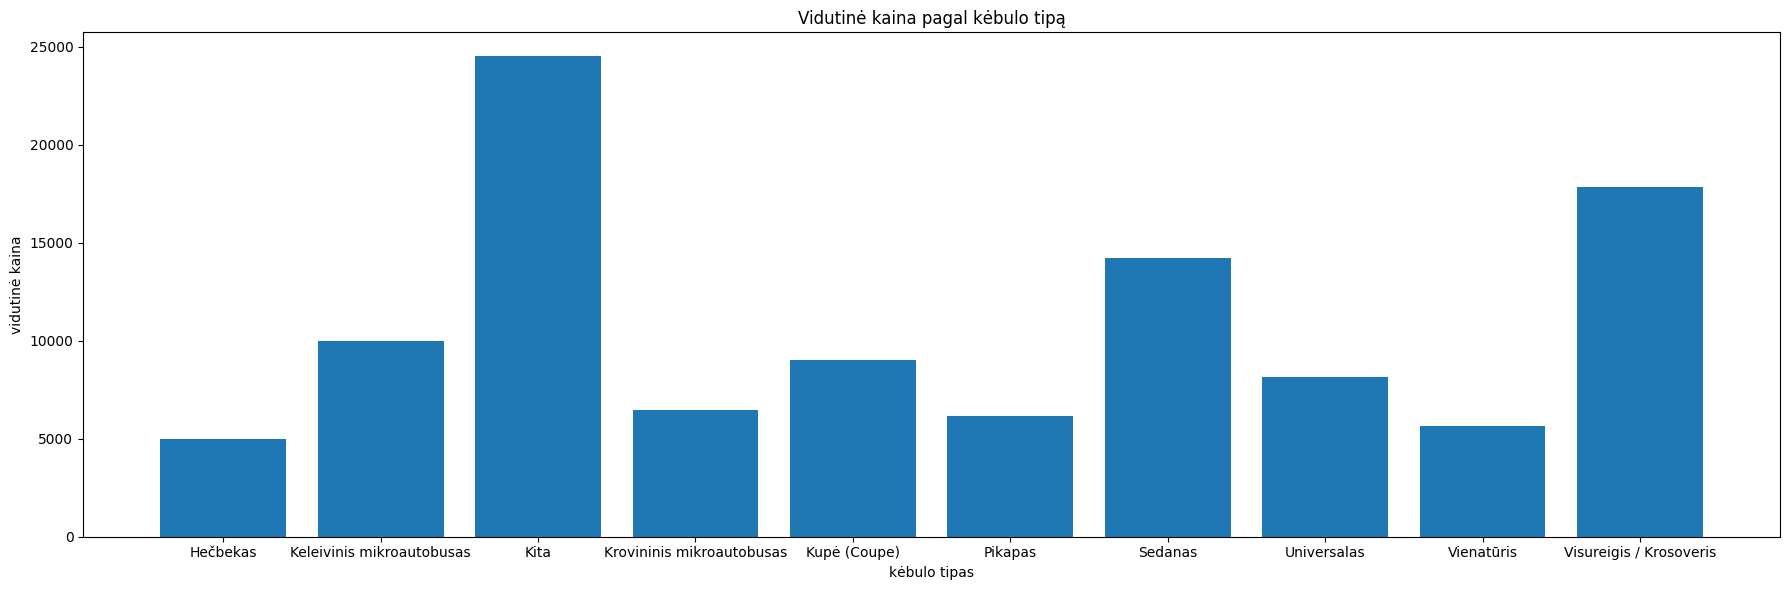

In [70]:
fig, axis = plt.subplots(figsize=(18, 6))

axis.bar(dfkebulas['kebulas'], dfkebulas['kaina'])
axis.set_xticks(dfkebulas['kebulas'])
axis.set_xlabel('kėbulo tipas')
axis.set_ylabel('vidutinė kaina')
plt.title('Vidutinė kaina pagal kėbulo tipą')


plt.tight_layout()
plt.show()